In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
CUDA = torch.cuda.is_available()

In [6]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [7]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [8]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [9]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        shape = y.size()
        _, ind = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1, shape[-1])
        y_hard.scatter_(1, ind.view(-1, 1), 1)
        y_hard = y_hard.view(*shape)
        return (y_hard - y).detach() + y
    else:
        return y

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [11]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [12]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [13]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [14]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)
    

In [15]:
class Decoder(nn.Module):  
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)      
        self.fc4 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        o = h4.view(-1,784)
        return F.sigmoid(o)

In [16]:
E = Encoder()
D = Decoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]

In [17]:
if CUDA:
    E.cuda()
    D.cuda()
    O0.cuda()
    [e.cuda() for e in Os]
    [e.cuda() for e in Ts]
    [e.cuda() for e in T1s]
    [e.cuda() for e in Gs]

In [18]:
import os
os.system('mkdir -p checkpoint_soft')
PATH = 'checkpoint_soft/hd_vae'
def save_model():
    torch.save(E.state_dict(), "{}_E".format(PATH))
    torch.save(D.state_dict(), "{}_D".format(PATH))
    torch.save(O0.state_dict(), "{}_O0".format(PATH))
    
    def save_list(models, name):
        for i in range(len(models)):
            torch.save(models[i].state_dict(), "{}_{}_{}".format(PATH, name, i))
    
    save_list(Os, 'Os')
    save_list(Ts, 'Ts')
    save_list(T1s, 'T1s')
    save_list(Gs, 'Gs')
    
#save_model()

In [19]:
from itertools import product
    
log_two_pow_n = Variable(torch.Tensor([2**N]).log(), requires_grad=False)
if CUDA:
    log_two_pow_n = log_two_pow_n.cuda()

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
        sofar = E(x)
        outputs = [O0(sofar)]

        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](path[n]) # Kind of doing "teacher forcing"
            outputs.append(Os[n](sofar))

        q = prob(outputs)

        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([x.shape[0]]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_n + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [20]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-04 *
  6.9696
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [21]:
x

Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 4x784 (GPU 0)]

In [22]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)/bsize # TODO eddie: changed from size_average=False
    # Assuming independent latent
#     KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x)
    return BCE, KLD

In [23]:
params = [
    {'params':E.parameters()},
    {'params':D.parameters()},
    {'params':O0.parameters()},
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] + [{'params': g.parameters()} for g in Gs]
optimizer = optim.Adam(params, lr=1e-4)

In [24]:
best_loss_sofar = 9999

In [25]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        samples = [sample(outputs[-1])]
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](samples[-1])
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
        bits = torch.cat(samples, dim=1)
        q = prob(outputs)
        recon_x = D(bits)
        BCE, KLD = loss_function(recon_x, x, q)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
#         if batch_idx % 200 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 BCE.data[0] / len(data),
#                 KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
        save_model()
        best_loss_sofar = avg_loss
        
    return q, bits # for debugging

In [26]:
%%time
for epoch in range(20):
    q, bits = train(epoch)

====> Epoch: 1 Average BCE loss: 2.3704, Average KLD loss: 0.0127, Total: 2.3831
Loss 2.3831258862551175 is better than previous best 9999, saving model
====> Epoch: 2 Average BCE loss: 1.9775, Average KLD loss: 0.0162, Total: 1.9937
Loss 1.9937368068496386 is better than previous best 2.3831258862551175, saving model
====> Epoch: 3 Average BCE loss: 1.9370, Average KLD loss: 0.0143, Total: 1.9513
Loss 1.9513368823270003 is better than previous best 1.9937368068496386, saving model
====> Epoch: 4 Average BCE loss: 1.9332, Average KLD loss: 0.0140, Total: 1.9472
Loss 1.9471824773510298 is better than previous best 1.9513368823270003, saving model
====> Epoch: 5 Average BCE loss: 1.9312, Average KLD loss: 0.0140, Total: 1.9452
Loss 1.9452260203739007 is better than previous best 1.9471824773510298, saving model
====> Epoch: 6 Average BCE loss: 1.9286, Average KLD loss: 0.0140, Total: 1.9426
Loss 1.942617157147328 is better than previous best 1.9452260203739007, saving model
====> Epoch: 

In [32]:
%%time
for epoch in range(20,40):
    q, bits = train(epoch)

====> Epoch: 21 Average BCE loss: 1.8872, Average KLD loss: 0.0139, Total: 1.9011
Loss 1.901144043767452 is better than previous best 1.9045341230928898, saving model
====> Epoch: 22 Average BCE loss: 1.8844, Average KLD loss: 0.0139, Total: 1.8983
Loss 1.898307335279385 is better than previous best 1.901144043767452, saving model
====> Epoch: 23 Average BCE loss: 1.8812, Average KLD loss: 0.0139, Total: 1.8951
Loss 1.8950898248414199 is better than previous best 1.898307335279385, saving model
====> Epoch: 24 Average BCE loss: 1.8787, Average KLD loss: 0.0139, Total: 1.8926
Loss 1.8925768343607585 is better than previous best 1.8950898248414199, saving model
====> Epoch: 25 Average BCE loss: 1.8767, Average KLD loss: 0.0139, Total: 1.8906
Loss 1.890572736154 is better than previous best 1.8925768343607585, saving model
====> Epoch: 26 Average BCE loss: 1.8739, Average KLD loss: 0.0139, Total: 1.8878
Loss 1.8878310186286766 is better than previous best 1.890572736154, saving model
====

In [36]:
%%time
for epoch in range(40,60):
    q, bits = train(epoch)

====> Epoch: 41 Average BCE loss: 1.8502, Average KLD loss: 0.0139, Total: 1.8641
Loss 1.8640969894647599 is better than previous best 1.8652785395463307, saving model
====> Epoch: 42 Average BCE loss: 1.8494, Average KLD loss: 0.0139, Total: 1.8634
Loss 1.8633516766428948 is better than previous best 1.8640969894647599, saving model
====> Epoch: 43 Average BCE loss: 1.8482, Average KLD loss: 0.0140, Total: 1.8622
Loss 1.8621606835941473 is better than previous best 1.8633516766428948, saving model
====> Epoch: 44 Average BCE loss: 1.8479, Average KLD loss: 0.0139, Total: 1.8618
Loss 1.8618241078535716 is better than previous best 1.8621606835941473, saving model
====> Epoch: 45 Average BCE loss: 1.8456, Average KLD loss: 0.0140, Total: 1.8595
Loss 1.8595488862752914 is better than previous best 1.8618241078535716, saving model
====> Epoch: 46 Average BCE loss: 1.8453, Average KLD loss: 0.0139, Total: 1.8592
Loss 1.8592168095787365 is better than previous best 1.8595488862752914, savin

In [40]:
%%time
for epoch in range(60,100):
    q, bits = train(epoch)

====> Epoch: 61 Average BCE loss: 1.8348, Average KLD loss: 0.0139, Total: 1.8487
====> Epoch: 62 Average BCE loss: 1.8340, Average KLD loss: 0.0139, Total: 1.8480
Loss 1.847971200199922 is better than previous best 1.8486060991267363, saving model
====> Epoch: 63 Average BCE loss: 1.8336, Average KLD loss: 0.0139, Total: 1.8475
Loss 1.8475190769116083 is better than previous best 1.847971200199922, saving model
====> Epoch: 64 Average BCE loss: 1.8322, Average KLD loss: 0.0139, Total: 1.8462
Loss 1.8461508153994879 is better than previous best 1.8475190769116083, saving model
====> Epoch: 65 Average BCE loss: 1.8323, Average KLD loss: 0.0139, Total: 1.8462
====> Epoch: 66 Average BCE loss: 1.8327, Average KLD loss: 0.0140, Total: 1.8467
====> Epoch: 67 Average BCE loss: 1.8312, Average KLD loss: 0.0139, Total: 1.8451
Loss 1.8450963131725788 is better than previous best 1.8461508153994879, saving model
====> Epoch: 68 Average BCE loss: 1.8305, Average KLD loss: 0.0139, Total: 1.8444
Lo

In [41]:
q

Variable containing:
( 0 ,.,.) = 
  1.0000  0.0000
  1.0000  0.0000
  0.5000  0.5000
  0.0253  0.9747
  0.5000  0.5000

( 1 ,.,.) = 
  1.0000  0.0000
  1.0000  0.0000
  0.5000  0.5000
  0.0011  0.9989
  0.5000  0.5000

( 2 ,.,.) = 
  1.0000  0.0000
  1.0000  0.0000
  0.5000  0.5000
  0.7484  0.2516
  0.5000  0.5000
... 

(97 ,.,.) = 
  1.0000  0.0000
  1.0000  0.0000
  0.5000  0.5000
  0.0000  1.0000
  0.5000  0.5000

(98 ,.,.) = 
  1.0000  0.0000
  1.0000  0.0000
  0.5000  0.5000
  0.6448  0.3552
  0.5000  0.5000

(99 ,.,.) = 
  1.0000  0.0000
  1.0000  0.0000
  0.5000  0.5000
  0.0003  0.9997
  0.5000  0.5000
[torch.cuda.FloatTensor of size 100x5x2 (GPU 0)]

In [42]:
bits

Variable containing:
 1.0000e+00  1.0000e+00  4.9830e-01  2.1830e-02  5.6833e-01
 1.0000e+00  1.0000e+00  1.6922e-01  8.1597e-04  4.9227e-01
 1.0000e+00  1.0000e+00  9.5309e-01  9.4371e-01  8.3041e-01
 1.0000e+00  1.0000e+00  6.6713e-01  5.5026e-02  6.4431e-01
 1.0000e+00  1.0000e+00  6.9525e-01  9.9756e-01  5.0073e-01
 1.0000e+00  1.0000e+00  3.5496e-01  1.0000e+00  8.7959e-01
 1.0000e+00  1.0000e+00  8.5790e-01  1.5517e-04  2.1823e-01
 1.0000e+00  1.0000e+00  4.9886e-01  3.8417e-06  2.0043e-01
 1.0000e+00  1.0000e+00  3.9946e-01  9.9722e-08  4.4015e-01
 1.0000e+00  1.0000e+00  4.7581e-01  5.2378e-01  5.9424e-01
 1.0000e+00  1.0000e+00  8.1944e-01  6.7078e-03  5.9366e-01
 1.0000e+00  1.0000e+00  1.0908e-01  1.0000e+00  9.3979e-01
 1.0000e+00  1.0000e+00  5.8044e-01  2.9256e-03  1.1270e-01
 1.0000e+00  1.0000e+00  1.2815e-01  1.2995e-02  6.1338e-01
 1.0000e+00  1.0000e+00  4.1772e-01  5.3594e-08  9.5370e-01
 1.0000e+00  1.0000e+00  4.7955e-01  8.6107e-01  7.0016e-02
 1.0000e+00  1.0000

In [43]:
#test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

In [44]:
# a = np.array([[0., 0., 0., 0.]])
# w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
# plt.imshow(w.view(28,28).data.numpy())

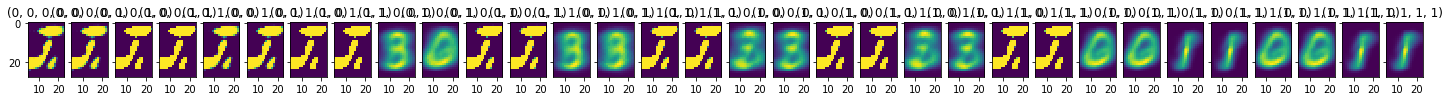

In [45]:
from itertools import product
f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
kk = 0
for path in product(range(2), repeat=N):
    v = Variable(torch.Tensor(path).type(torch.FloatTensor))
    if CUDA:
        v = v.cuda()
    w = D.forward(v)
    ax = axes[kk]
    ax.set_title(path)
    ax.imshow(w.view(28,28).cpu().data.numpy())
    kk += 1